## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import cfe.regression as rgsn
import warnings
warnings.filterwarnings('ignore')

Missing dependencies for OracleDemands.


### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [3]:
InputFiles = {'Expenditures':('1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0','Expenditures'),
              'Prices':('1XaJJuVpHAJ2kK-wOg7CfdENc6XISYY_NKL0lK9wGEcU','Food Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('13cuZwMSDFtiDxUARUQc72kLj2QDv5gqPGbgjTijuUzc','For Use in Code'),
              'RDI':('1KS9270VK5mkFXalZPavxa85rHg3jiuLyL-oetUrf1m4','diet_minimums'),}

#### Prices, FCT, RDI



In [4]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    return get_clean_df(df)

def get_clean_df(df):
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]
    
    return df
    

# Get prices
#p = get_clean_sheet(InputFiles['Prices'][0],sheet=InputFiles['Prices'][1])

#p = read_sheets(InputFiles['Prices'][0],sheet=InputFiles['Prices'][1])
p = pd.read_pickle('Tanzania_prices_clean.pickle')
p = p.rename({'': 'units'},axis=1) #Rename units column
p = p.loc[p['units']!='piece'] #Only use kg units..
p = pd.DataFrame(np.vstack([p.columns, p])) # Make t column header as a row
p = p.drop(1, axis=1) # Drop units column
p = p.T #Transpose p
p.columns = p.iloc[0] #Make first row into column header
p = p.drop(0, axis=0) #Drop first row (current column header)
p = p.reset_index(drop=True)

p = get_clean_df(p)

p = p.drop('j',axis=1)

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.rename(columns={"Item name": "j"})

fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.drop('Value',axis=1)

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct = fct.dropna(how='all',axis=0)

################## RDI, if available (consider using US) ##################### ## CHECK: Are we using US or Tanzania?
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])

rdi = rdi.rename(columns={"Nutrition": "n"})
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [5]:
r = rgsn.read_pickle('Tanzania_results_clean.pickle')  # Assumes you've already set this up e.g., in Project 3

In [6]:
r

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [7]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2010-11',level='t').mean()

pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [8]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [9]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

j                             Beef including minced sausage  Bread, white   
i     t       m                                                             
1     2012-13 Mainland Rural                       0.551144      0.821665  \
      2014-15 Mainland Rural                       1.079740      1.232589   
2     2014-15 Mainland Rural                       1.002736      1.140526   
4     2012-13 Mainland Rural                       0.175307      0.293495   
      2014-15 Mainland Rural                       0.768933      0.972607   
...                                                     ...           ...   
14974 2014-15 Mainland Rural                       0.745600      0.957667   
14979 2014-15 Mainland Rural                       2.155110      2.615543   
14980 2014-15 Mainland Rural                       1.143796      1.468250   
14981 2014-15 Mainland Rural                       1.565504      2.366574   
14983 2014-15 Mainland Rural                       1.212981      1.379023   

j                             Cassava Fresh, raw  Chicken and other poultry   
i     t       m                                                               
1     2012-13 Mainland Rural            3.556712                   0.705010  \
      2014-15 Mainland Rural            3.863495                   1.530448   
2     2014-15 Mainland Rural            3.284932                   1.499176   
4     2012-13 Mainland Rural            1.362309                   0.222338   
      2014-15 Mainland Rural            2.602902                   1.241555   
...                                          ...                        ...   
14974 2014-15 Mainland Rural            3.034524                   1.193524   
14979 2014-15 Mainland Rural            5.596466                   2.869056   
14980 2014-15 Mainland Rural            3.231027                   1.626623   
14981 2014-15 Mainland Rural            5.455725                   2.564741   
14983 2014-15 Mainland Rural            3.948147                   1.769135   

j                             Coconuts (mature/immature)   
i     t       m                                            
1     2012-13 Mainland Rural                    1.183172  \
      2014-15 Mainland Rural                    1.981430   
2     2014-15 Mainland Rural                    1.887895   
4     2012-13 Mainland Rural                    0.554394   
      2014-15 Mainland Rural                    1.659539   
...                                                  ...   
14974 2014-15 Mainland Rural                    1.504525   
14979 2014-15 Mainland Rural                    3.373652   
14980 2014-15 Mainland Rural                    2.092740   
14981 2014-15 Mainland Rural                    2.967146   
14983 2014-15 Mainland Rural                    2.093970   

j                             Cooking bananas (/Plantains)   
i     t       m                                              
1     2012-13 Mainland Rural                      1.894480  \
      2014-15 Mainland Rural                      2.620288   
2     2014-15 Mainland Rural                      2.755578   
4     2012-13 Mainland Rural                      0.767059   
      2014-15 Mainland Rural                      2.333625   
...                                                    ...   
14974 2014-15 Mainland Rural                      2.075388   
14979 2014-15 Mainland Rural                      5.715056   
14980 2014-15 Mainland Rural                      3.196193   
14981 2014-15 Mainland Rural                      4.673541   
14983 2014-15 Mainland Rural                      3.216082   

j                             Cooking oil (vegetable oil)     Dairy   
i     t       m                                                       
1     2012-13 Mainland Rural                     0.370306  0.480318  \
      2014-15 Mainland Rural                     0.624308  1.459413   
2     2014-15 Mainland Rural                     0.672102  1.545156   
4     2012-13 Mainland Rura

Finally, define a function to change a single price in the vector $p$:



In [10]:
def my_prices(p0,p=pbar,j='Sugar'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



<IPython.core.display.Javascript object>


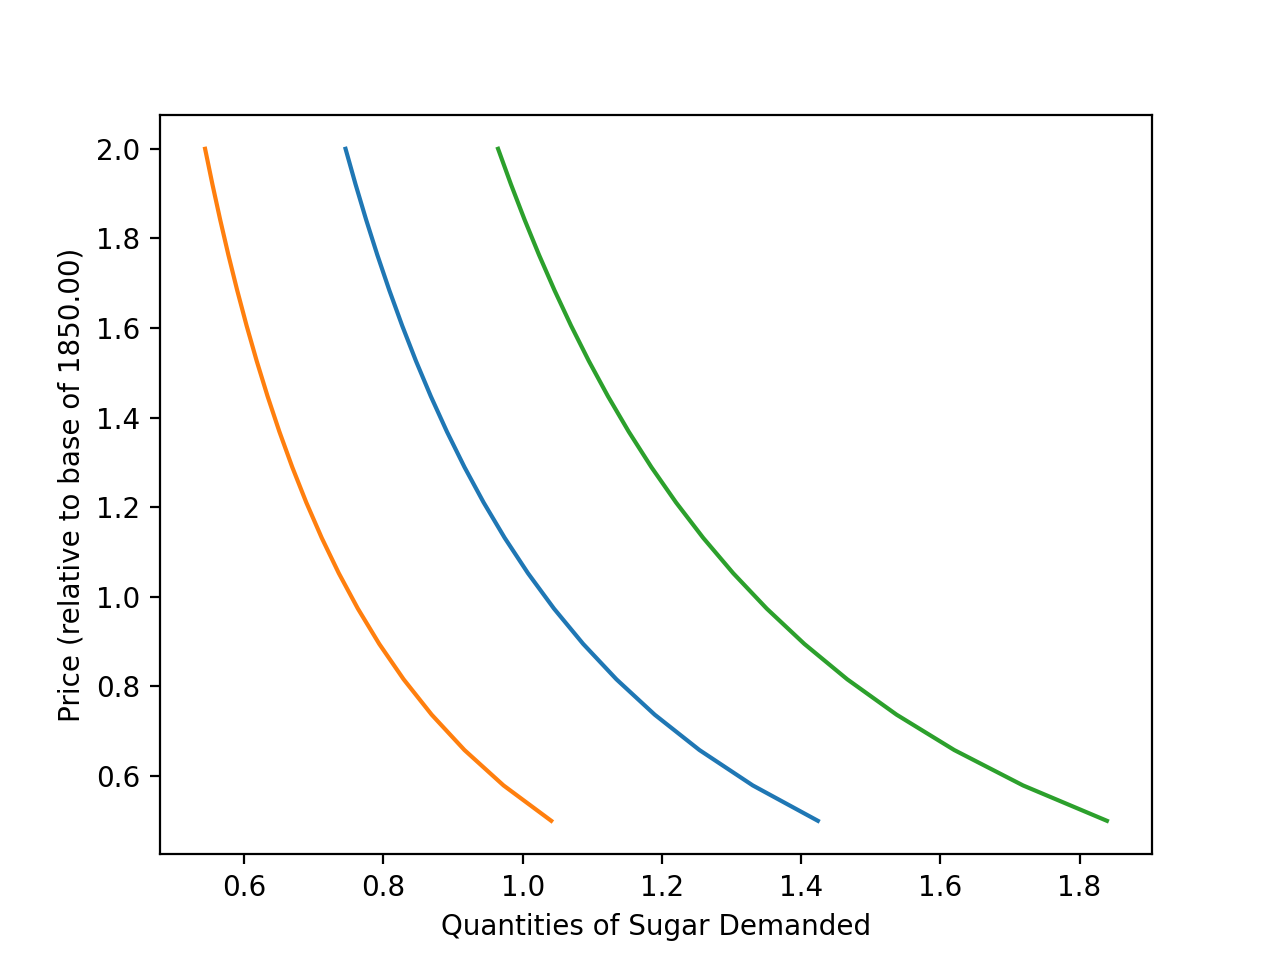

Text(0.5, 0, 'Quantities of Sugar Demanded')

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Sugar'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



<IPython.core.display.Javascript object>


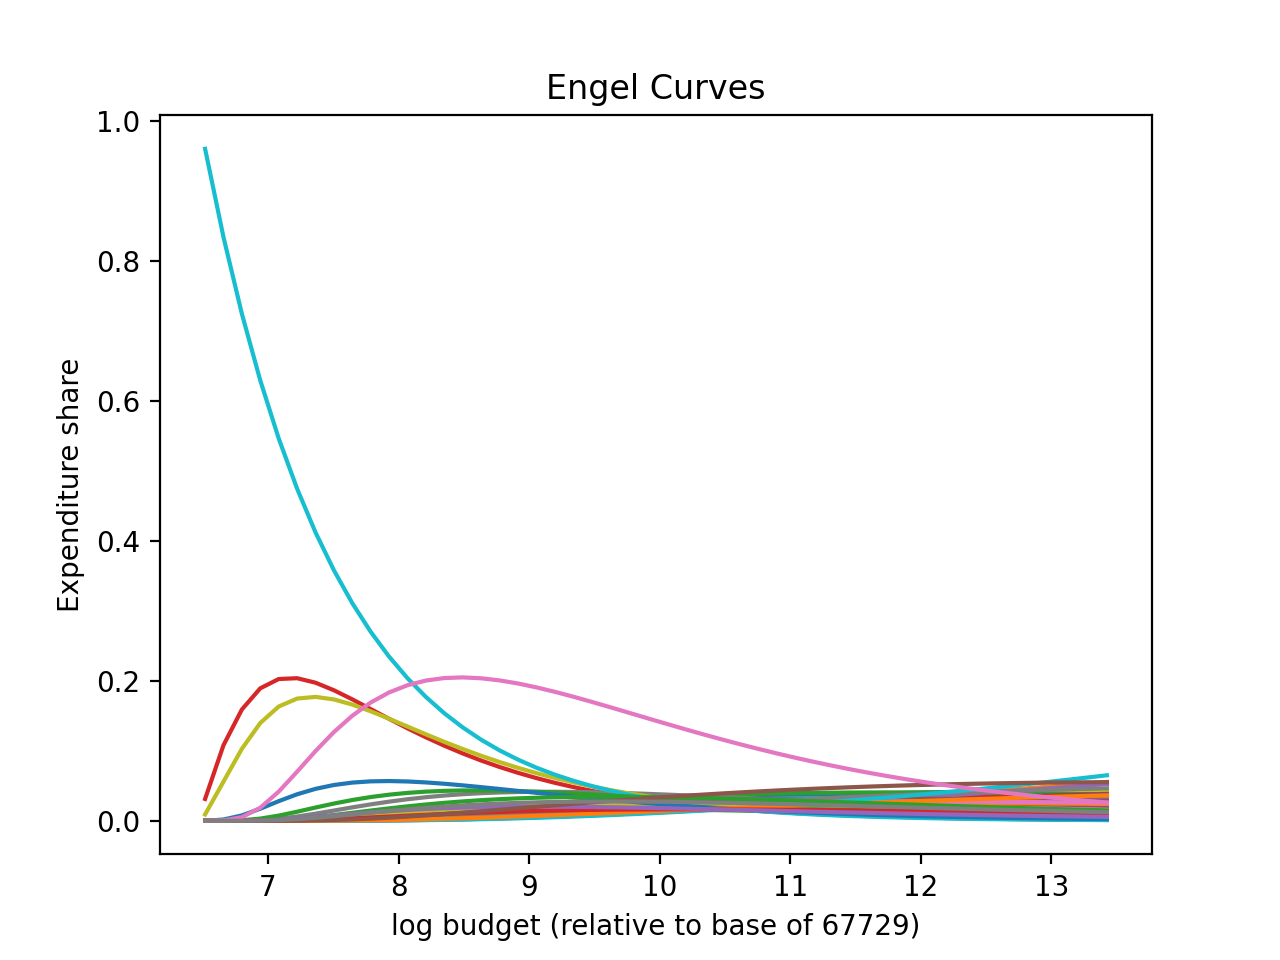

Text(0.5, 1.0, 'Engel Curves')

In [12]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [13]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Rice (Husked) (white grain raw)', 'Maize (Flour, dry)',
       'Millet and Sorghum (Flour)', 'Bread, white', 'Macaroni (/Spaghetti)',
       'Cassava Fresh, raw', 'Sweet potatoes, fresh AP',
       'Irish potatoes, cooked (English)', 'Sugar',
       'Sweets (Candy, Chocolate)',
       'Honey (/Syrups, jams, marmalade, jellies, canned fruits)',
       'Lentil, cooked / Peas (/Beans, lentils and other pulses)',
       'Groundnuts in shell/shelled', 'Coconuts (mature/immature)',
       'Onion, raw (/tomatoes, carrots and green pepper, other viungo)',
       'Spinach, cooked (/cabbage and other green vegetables)', 'Ripe Bananas',
       'Oranges (citrus fruits)', 'Beef including minced sausage',
       'Chicken and other poultry', 'Eggs',
       'Raw Fresh fish and seafood (including dagaa)',
       'Dried/salted/canned fish and seafood (including dagaa)', 'Fresh milk',
       'Cooking oil (vegetable oil)', 'Salt', 'Tea dry',
       'Mango juice (soda, juice, water)'],
      dtype=

Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [14]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i                                       1                             2       
t                                     2012-13        2014-15        2014-15   
m                              Mainland Rural Mainland Rural Mainland Rural   
n                                                                             
Energy                            7883.942757    9857.144202    8800.819084  \
Protein                            223.254619     318.368235     302.679979   
Vitamin A, RAE                    3874.342205    5191.926227    5267.576661   
Vitamin D (calciferol)               7.580135      15.342443      16.938451   
Vitamin E (alpha-tocopherol)        33.868264      45.526905      44.443046   
Vitamin C, total ascorbic acid     206.691068     304.922541     297.722898   
Vitamin B-6                          9.333862      13.545919      13.356067   
Vitamin B-12                        16.905137      30.067640      33.799887   
Calcium, Ca                       1340.856809    1982.166992    1931.323102   
Magnesium, Mg                     1845.051222    2116.721050    1835.963590   
Iron, Fe                            60.230164      73.624604      62.848214   
Zinc, Zn                            34.142025      42.654308      37.267650   

i                                       4                             5       
t                                     2012-13        2014-15        2012-13   
m                              Mainland Rural Mainland Rural Mainland Rural   
n                                                                             
Energy                            4325.562915    8402.187593   17670.699891  \
Protein                            110.903478     265.994780     539.332122   
Vitamin A, RAE                    1380.898885    3900.728162    7989.874680   
Vitamin D (calciferol)               2.675377      12.712735      21.551684   
Vitamin E (alpha-tocopherol)        15.782737      37.443758      75.331262   
Vitamin C, total ascorbic acid      73.841678     221.300585     488.961534   
Vitamin B-6                          4.496589      11.291777      23.282538   
Vitamin B-12                         6.270092      24.599016      50.135070   
Calcium, Ca                        620.801563    1646.553805    3485.074003   
Magnesium, Mg                     1099.976739    1841.287582    3956.557554   
Iron, Fe                            34.360174      62.877473     131.438687   
Zinc, Zn                            18.896034      36.318404      76.483284   

i                                                      8                      
t                                     2014-15        2012-13        2014-15   
m                              Mainland Rural Mainland Rural Mainland Rural   
n                                                                             
Energy                           18943.867972    9310.049487   10547.737379  \
Protein                            638.173106     272.703802     326.184743   
Vitamin A, RAE                    9146.490223    3985.914876    4710.171491   
Vitamin D (calciferol)              28.792361      11.215524      15.426909   
Vitamin E (alpha-tocopherol)        88.220369      37.995818      45.370080   
Vitamin C, total ascorbic acid     588.724366     237.556490     274.640200   
Vitamin B-6                         28.243875      11.748866      14.113497   
Vitamin B-12                        66.991586      24.813752      31.269115   
Calcium, Ca                       3838.910809    1698.557906    1999.161882   
Magnesium, Mg                     4046.255677    2115.615276    2335.913406   
Iron, Fe                           138.789899      68.538797      78.559429   
Zinc, Zn                            82.733528      39.606837      45.438554   

i                                       9      ...                14966   
t                                     2012-13  ...              2014-15   
m                              Mainland Rural  ... Main

Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [15]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    #print(c)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    #print(fct0)
    #print(c0)
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



<IPython.core.display.Javascript object>


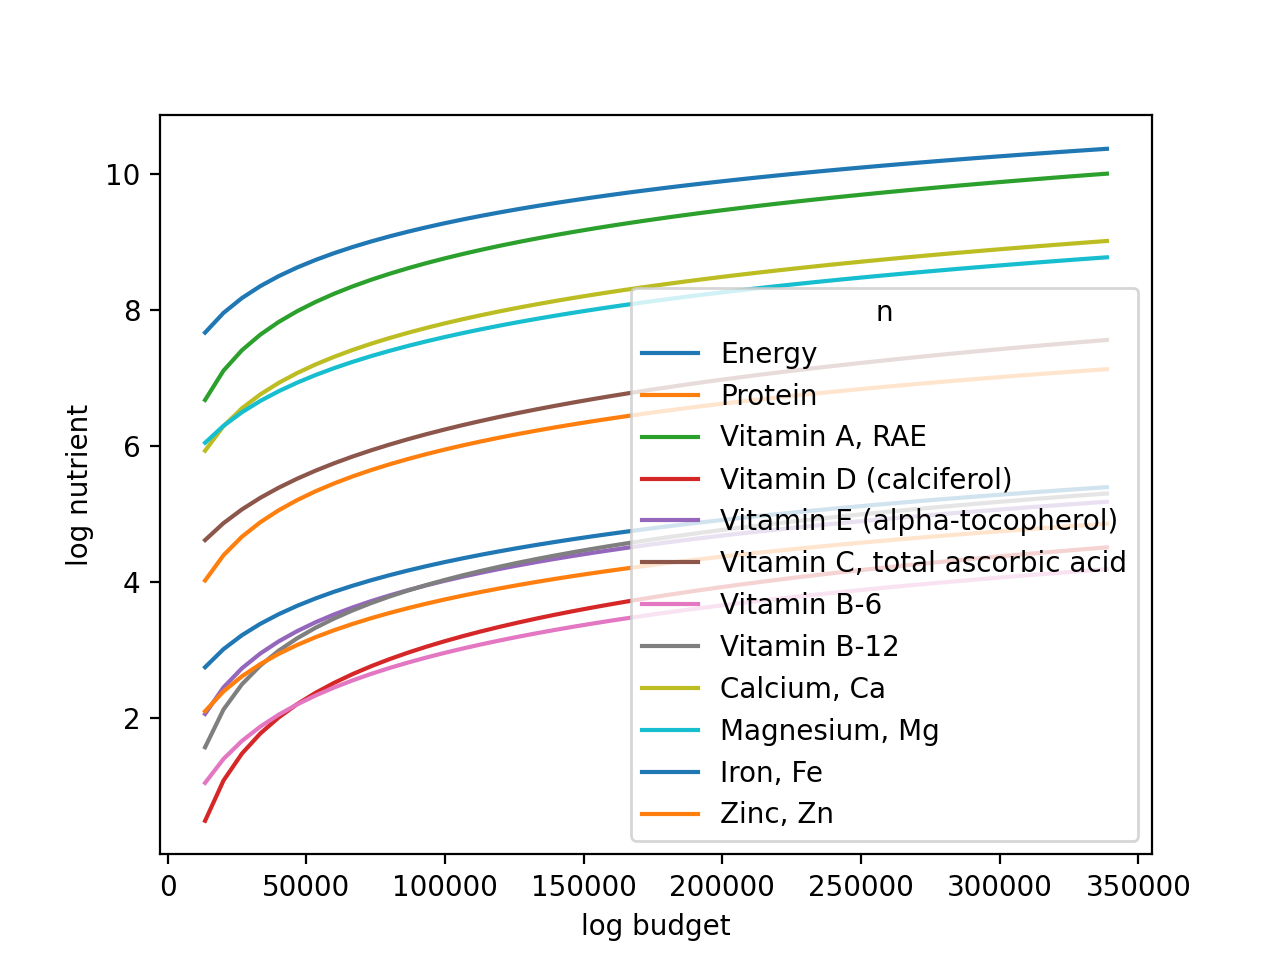

Text(0, 0.5, 'log nutrient')

In [16]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = list(N.index)

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
#df = pd.DataFrame({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X}).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



<IPython.core.display.Javascript object>


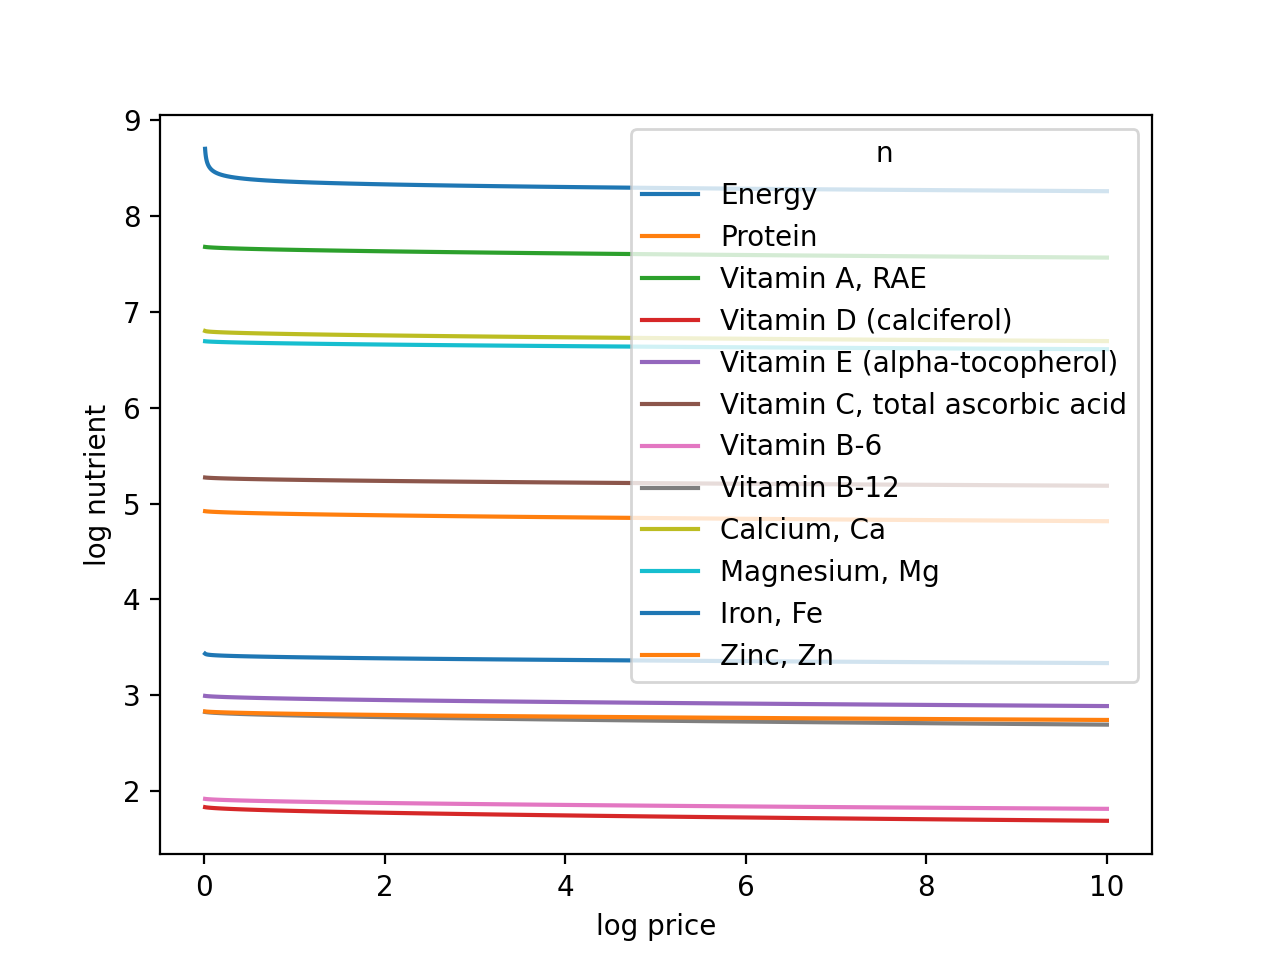

Text(0, 0.5, 'log nutrient')

In [17]:
USE_GOOD = 'Sugar'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [18]:
# In first round, averaged over households and villages
dbar = r.d.mean().iloc[:-2]

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [19]:
rdi = rdi.drop("Source",axis=1)
rdi["Males 00-03"] = rdi["C 1-3"]
rdi_map = {'C 1-3': 'Females 00-03', 'F 4-8': 'Females 04-08', 'F 9-13': 'Females 09-13', 'F 14-18': 'Females 14-18', 
 'F 19-30': 'Females 19-30', 'F 31-50': 'Females 31-50', 'F 51+': 'Females 51-99', 
 'M 4-8' : 'Males 04-08', 'M 9-13' : 'Males 09-13', 'M 14-18': 'Males 14-18', 'M 19-30': 'Males 19-30', 
 'M 31-50': 'Males 31-50', 'M 51+' : 'Males 51-99'}

In [20]:
rdi = rdi.rename(columns = rdi_map)
rdi

k,Females 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99,Males 00-03
n,,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0,1000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0,13.0
"Fiber, total dietary",14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0,14.0
"Folate, DFE",150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,150.0
"Calcium, Ca",700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0,700.0
"Carbohydrate, by difference",130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
"Iron, Fe",7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0,7.0
"Magnesium, Mg",80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0,80.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0,6.0


In [21]:
dbar = dbar.drop("log HSize")

In [22]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar

hh_rdi

n
Energy                            11928.575871
Protein                             264.443874
Fiber, total dietary                167.000062
Folate, DFE                        2224.214863
Calcium, Ca                        7265.143035
Carbohydrate, by difference         891.284204
Iron, Fe                             73.727767
Magnesium, Mg                      1898.529229
Niacin                               84.801617
Phosphorus, P                      5476.229789
Potassium, K                      29670.600124
Riboflavin                            6.645849
Thiamin                               6.457836
Vitamin A, RAE                     4428.093905
Vitamin B-12                         13.345289
Vitamin B-6                           7.352985
Vitamin C, total ascorbic acid      397.862251
Vitamin E (alpha-tocopherol)         82.938277
Vitamin K (phylloquinone)           527.874689
Zinc, Zn                             53.684546
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [23]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



<IPython.core.display.Javascript object>


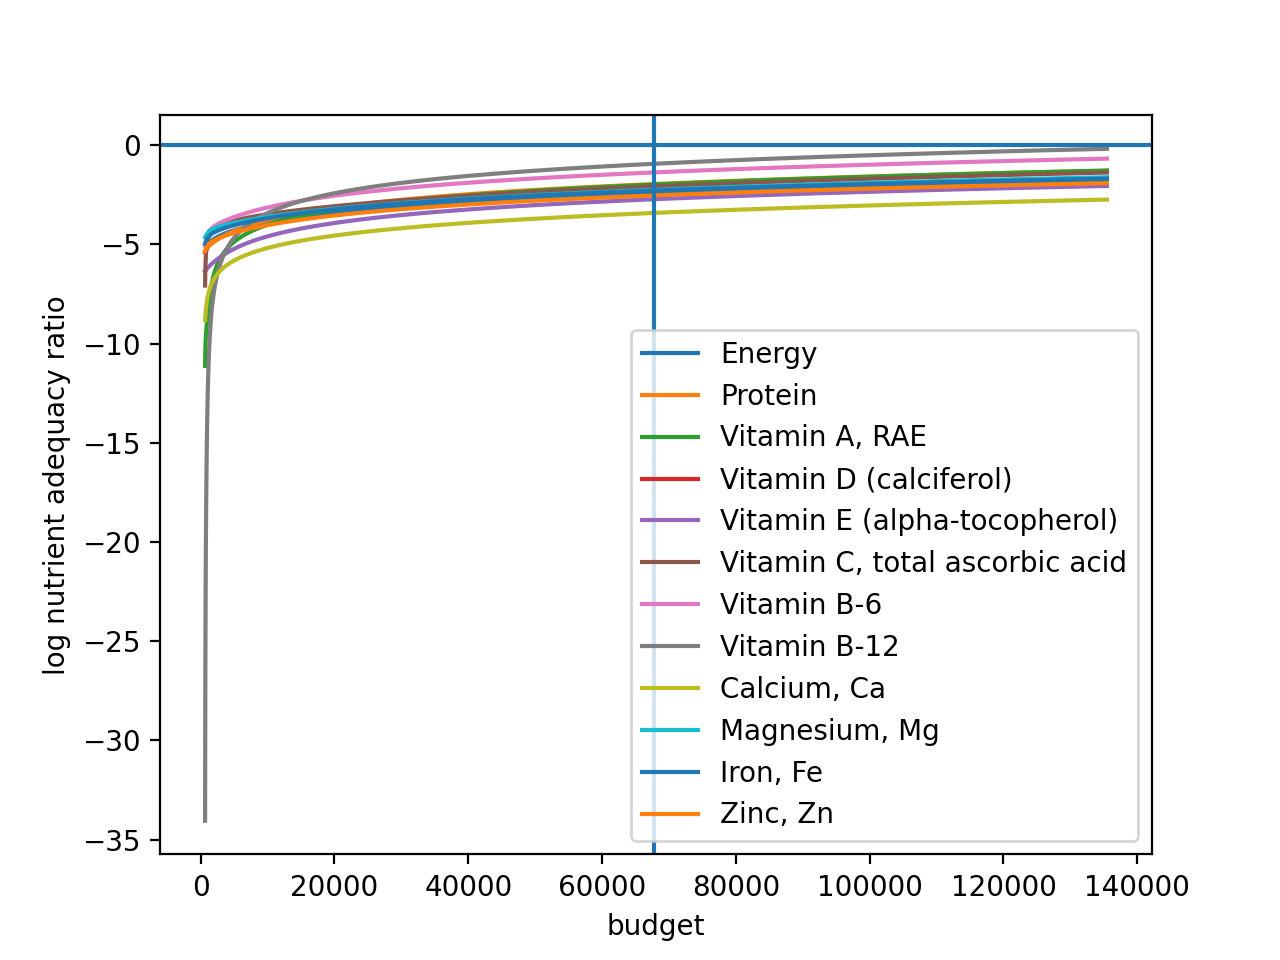

In [24]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



<IPython.core.display.Javascript object>


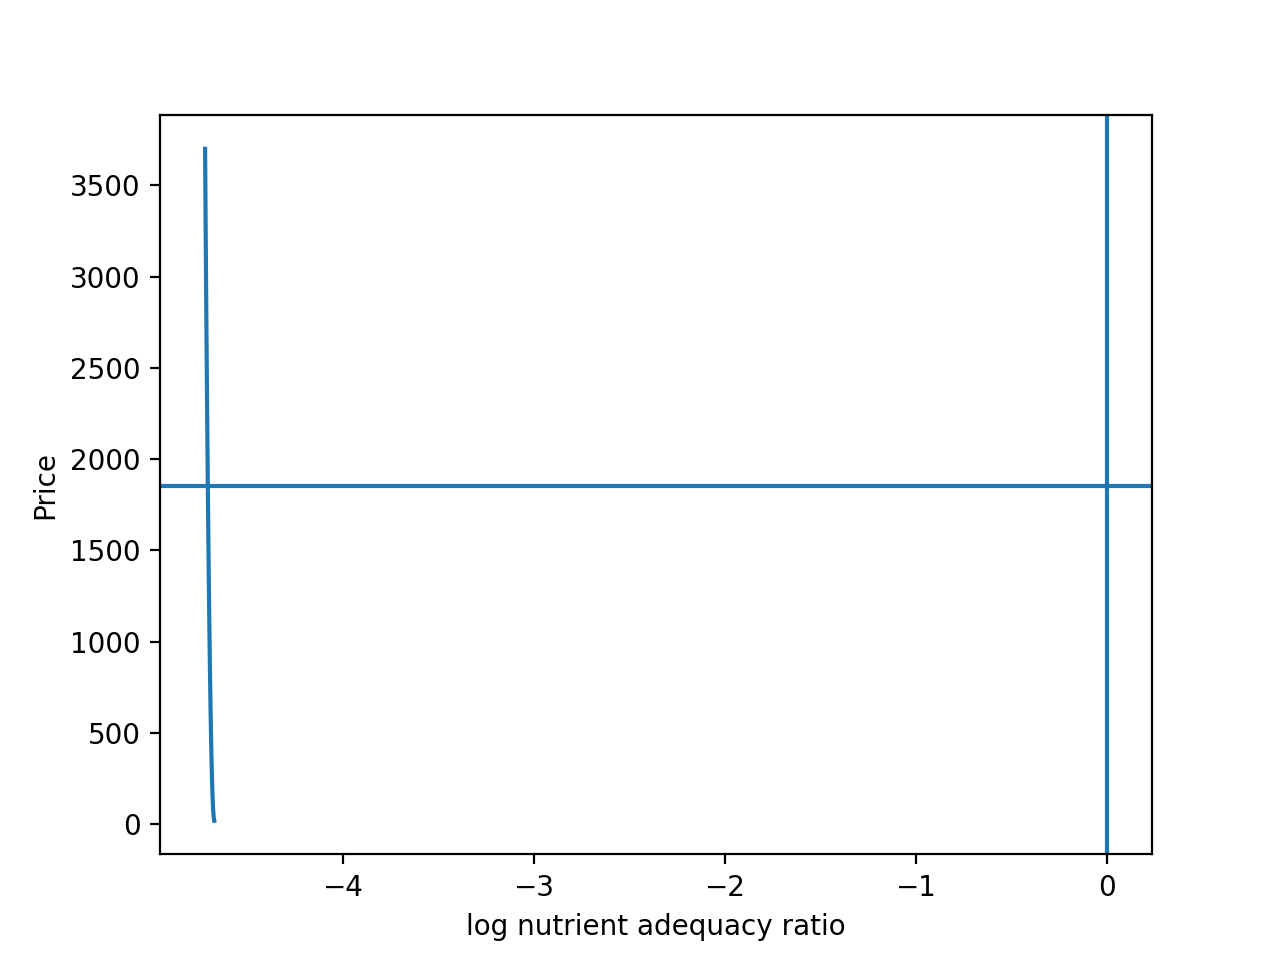

Text(0.5, 0, 'log nutrient adequacy ratio')

In [25]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Calcium, Ca'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

We Worked through calculating nutritional demands and adequacy above.

We will now work through example calculating costs of price changes

## Policy: Calculating Costs of Price Changes

#### Reference Prices

Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.

In [26]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2010-11',level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets

Get food budget for all households, then find median budget:

In [27]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

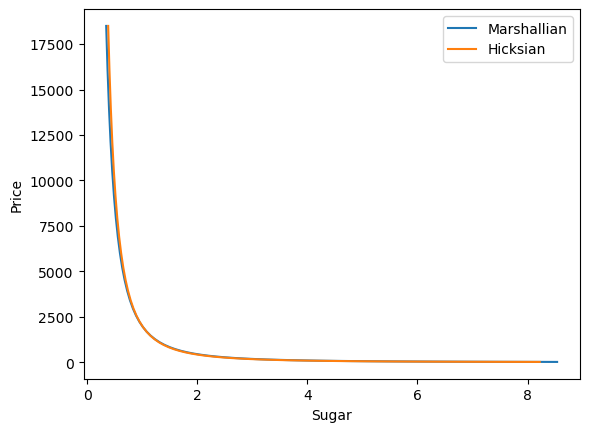

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Sugar'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = r.indirect_utility(x0,pbar)

plt.plot([r.demands(x0,my_prices(p0,j=my_j))[my_j] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,j=my_j),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

#### Welfare measures

In [29]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation

Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.

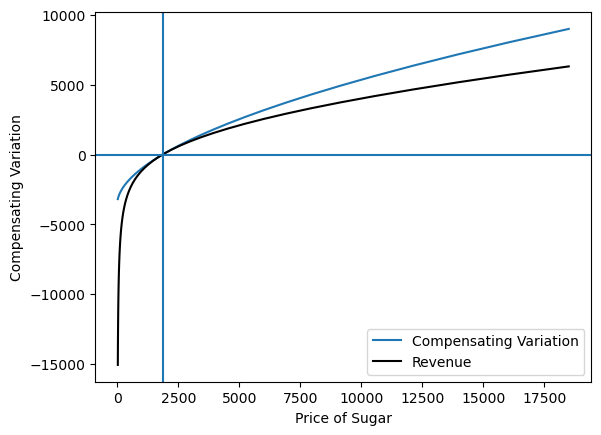

In [30]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss

Differences between revenue and compensating variation is deadweight-loss:

Text(0, 0.5, 'Deadweight Loss')

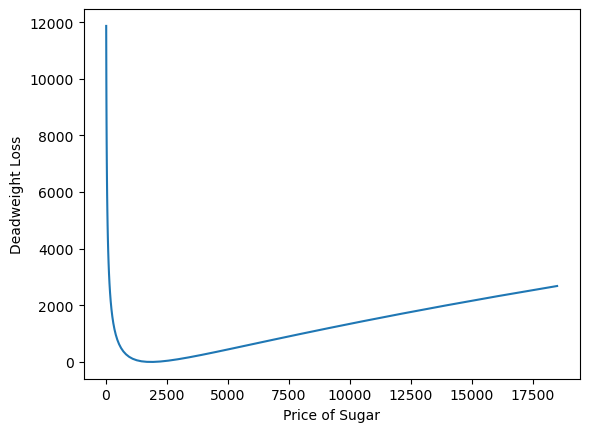

In [31]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")